# RAMP on text classification

*Moustapha Mohamed Mahmoud, Mohamed Vadhel Ebnou Oumar, Sonali Patekar, Niclas Tollot, Abdellahi Ebnou Oumar, Yao ?*

## Table of Contents

## Introduction

## Getting started with the RAMP starting kit

### Software prerequisites

## Downloading the data

The train and test data can be downloaded by running from the root of the starting kit:

    python download_data.py


### Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
tf.__version__

'2.10.1'

#### install data full-corpus.csv from this link https://github.com/zfz/twitter_corpus

### The Data

In [5]:
df = pd.read_csv('full-corpus.csv') # Should be repalced with get_train_data()

In [6]:
df.head()

,Unnamed: 0,Topic,Sentiment,TweetId,TweetDate,TweetText
0,0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [15]:
df.sample(n=5113).reset_index(drop=True)

,Unnamed: 0,Topic,Sentiment,TweetId,TweetDate,TweetText
0,4734,twitter,irrelevant,126873574895140864,Thu Oct 20 04:13:12 +0000 2011,Disculpame #twitter te e tenido algo avandonad...
1,1888,google,neutral,126492759262633984,Wed Oct 19 02:59:58 +0000 2011,Just wonder how much time it will take throw a...
2,2706,microsoft,neutral,126797209244151808,Wed Oct 19 23:09:45 +0000 2011,"Microsoft opens the spigot, Windows Phone Mang..."
3,1443,google,neutral,126530553477468160,Wed Oct 19 05:30:09 +0000 2011,G#Music Unites #Google Music with #Apple iOS [...
4,1922,google,neutral,126490278143082496,Wed Oct 19 02:50:07 +0000 2011,@5in_n_the_Air #GOOGLE time kml
...,...,...,...,...,...,...
5108,2824,microsoft,neutral,126740408926609409,Wed Oct 19 19:24:02 +0000 2011,Microsoft CEO Looks Ahead at Social and Mobile...
5109,811,apple,neutral,125817967240949760,Mon Oct 17 06:18:35 +0000 2011,What's up with @apple stock going up after #St...
5110,620,apple,neutral,126104490511319041,Tue Oct 18 01:17:08 +0000 2011,If the iPhone 4 case fits the 4S why is @nleve...
5111,4705,twitter,irrelevant,126874654055989248,Thu Oct 20 04:17:29 +0000 2011,as indiretaa ta solta hoje nesse #twitter UAHS...


In [7]:
df.shape

(5113, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5113 non-null   int64 
 1   Topic       5113 non-null   object
 2   Sentiment   5113 non-null   object
 3   TweetId     5113 non-null   int64 
 4   TweetDate   5113 non-null   object
 5   TweetText   5113 non-null   object
dtypes: int64(2), object(4)
memory usage: 239.8+ KB


In [9]:
df.isnull().sum()

Unnamed: 0    0
Topic         0
Sentiment     0
TweetId       0
TweetDate     0
TweetText     0
dtype: int64

In [10]:
# here we have 4 classes of sentiment
df['Sentiment'].unique()

array(['positive', 'negative', 'neutral', 'irrelevant'], dtype=object)

In [11]:
df['Sentiment'].value_counts()

neutral       2333
irrelevant    1689
negative       572
positive       519
Name: Sentiment, dtype: int64

<AxesSubplot: >

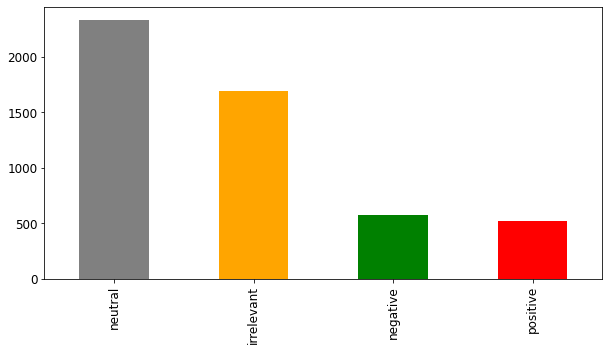

In [12]:
df['Sentiment'].value_counts().plot(kind='bar', color=['grey', 'orange', 'green', 'red'], figsize=(10, 5), fontsize=12)

In [58]:
X = df.drop('Sentiment',axis = 1)
y = df['Sentiment']

In [59]:
X.shape

(5113, 4)

In [60]:
y.shape

(5113,)

#### Label encoder

We will start by encoding the labels using `sklearn.preprocessing`

In [ ]:
from sklearn import preprocessing

labels = df['Sentiment'].values
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

### Cleaning the dataset

The goal of cleaning text data is to remove noise, irrelevant information, and inconsistencies that can negatively impact the performance of machine learning algorithms. In this section, we will apply basic techniques such as removing stop words, stemming, removing punctuation and special characters.

#### Removing ponctuations

In [36]:
X['TweetText'][0]

'Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is'

In [37]:
X['TweetText'].replace(to_replace = r'[^\w\s]', value = '', regex = True, inplace = True)

In [38]:
X['TweetText'][0]

'Now all Apple has to do is get swype on the iphone and it will be crack Iphone that is'

In [50]:
texts = X['TweetText'].values.copy()

#### Tokenization

In [39]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define a list of stop words
stop_words = set(stopwords.words('english'))
tokenized_corpus = [nltk.word_tokenize(sentence) for sentence in texts]
# Corpus_stemmed = [[ps.stem(word) for word in sentence] for sentence in tokenized_corpus] # don't know if i need this (seems not used in the solution)
tokenized_corpus = [[word.lower() for word in sentence] for sentence in tokenized_corpus]
# Remove stopwords
tokenized_corpus = [[word for word in sentence if word not in stop_words] for sentence in tokenized_corpus]

X["tokenized_text"] = pd.Series(tokenized_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moustapha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [53]:
tokenized_corpus

[['apple', 'get', 'swype', 'iphone', 'crack', 'iphone'],
 ['apple', 'adding', 'carrier', 'support', 'iphone', '4s', 'announced'],
 ['hilarious',
  'youtube',
  'video',
  'guy',
  'duet',
  'apple',
  'siri',
  'pretty',
  'much',
  'sums',
  'love',
  'affair',
  'httptco8exbnqjy'],
 ['rim', 'made', 'easy', 'switch', 'apple', 'iphone', 'see', 'ya'],
 ['realized', 'reason', 'got', 'twitter', 'ios5', 'thanks', 'apple'],
 ['im',
  'current',
  'blackberry',
  'user',
  'little',
  'bit',
  'disappointed',
  'move',
  'android',
  'apple',
  'iphone'],
 ['16',
  'strangest',
  'things',
  'siri',
  'said',
  'far',
  'sooo',
  'glad',
  'apple',
  'gave',
  'siri',
  'sense',
  'humor',
  'httptcotwaeudbp',
  'via',
  'happyplace'],
 ['great',
  'close',
  'personal',
  'event',
  'apple',
  'tonight',
  'regent',
  'st',
  'store'],
 ['companies',
  'experience',
  'best',
  'customer',
  'service',
  'aside',
  'zappos',
  'apple'],
 ['apply', 'job', 'apple', 'hope', 'call', 'lol'],
 ['

In [ ]:
!pip install wordcloud

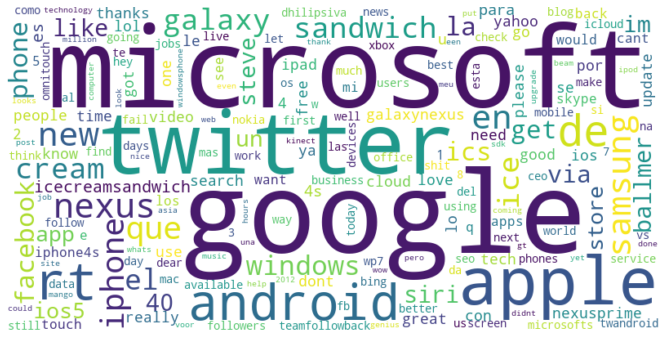

In [69]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Flatten the corpus into a single list of words
words = [word for sentence in tokenized_corpus for word in sentence]

# Count the frequency of each word
word_freq = Counter(words)

# Create a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Text embeddings

Text embeddings are a fundamental concept in Natural Language Processing (NLP) that allow us to represent text data as dense vectors of fixed length. Text embeddings capture the meaning and semantic relationships between words and documents, and enable us to apply machine learning algorithms to analyze and process text data.

Text embeddings can be generated using various techniques, such as Word2Vec, GloVe, and FastText, which are unsupervised learning algorithms that learn vector representations of words based on their co-occurrence statistics in a large corpus of text. These embeddings can be further improved by using supervised learning techniques that take into account the task-specific labels or feedback.

In this section, we will explore the concept of text embeddings and how to generate and use some of them. We will cover the basics of TD-IDF and GloVe.

In [51]:
train_texts, test_texts, train_y, test_y = train_test_split(
    tokenized_corpus, labels, test_size=.2)

### TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency. The basic idea behind TF-IDF is to give more weight to terms that appear frequently in a document but are rare in the corpus as a whole, as such terms are likely to be more informative and characteristic of the content of the document. 

By calling $D$ the set of documents (*tweets*), TF-IDF for a word $w$ in a document $d$ is calculated by multiplying two different metrics:$$\textrm{TF-IDF}(w, d, D) = \textrm{TF}(w, d) \times \textrm{IDF}(w, D)$$
Where :
    $$\textrm{TF}(w, d) = \log(1 + \textrm{freq}(w, d))$$
    $$\textrm{IDF}(w, D) = \log(\frac{|D|}{|\{d\in D, w \in d\}|})$$

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = X['TweetText'].values.copy()
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000, strip_accents='unicode')
X_tf = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['000', '10', '100', '1000aday', '11', '13', '15', '16', '17', '18',
       '19', '1st', '20', '2008', '2010', '2011', '2012', '24', '25',
       '30', '360', '39', '40', '499', '4s', '50', '500', '70', '78k',
       '99', 'aan', 'able', 'access', 'according', 'account', 'accounts',
       'actually', 'ad', 'add', 'addicted', 'ads', 'advertising',
       'adwords', 'age', 'agora', 'agree', 'ah', 'ahora', 'ai', 'air',
       'al', 'als', 'amazing', 'amazon', 'analytics', 'android',
       'android4', 'announce', 'announced', 'announcement', 'announces',
       'answer', 'antiguo', 'app', 'apparently', 'apple', 'applies',
       'apps', 'appsense', 'appstore', 'aqui', 'article', 'asi', 'asia',
       'asiaclassifiedtoday', 'ask', 'ass', 'att', 'attacks', 'auf',
       'augnl', 'autopilot', 'available', 'avec', 'away', 'awesome',
       'azure', 'baby', 'bad', 'ballmer', 'bar', 'based', 'battery',
       'battle', 'beam', 'beat', 'beautiful', 'bed', 'begin', 'believe',
       'ben',

In [71]:
X_tf.shape

(5113, 1000)

### Glove embedding

In [91]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]])
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.twitter.27B.25d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

# Transform text into GloVe embeddings
def transform_text_to_glove_embeddings(tokens, embeddings):

    # Compute average GloVe embedding
    embedding_dim = len(embeddings[next(iter(embeddings))])
    embedding_sum = np.zeros(embedding_dim)
    num_embeddings = 0
    for token in tokens:
        if token in embeddings:
            embedding_sum += embeddings[token]
            num_embeddings += 1
    if num_embeddings > 0:
        embedding_avg = embedding_sum / num_embeddings
    else:
        embedding_avg = np.zeros(embedding_dim)

    return embedding_avg


In [90]:
X["glove_embeddings"] = X["tokenized_Text"].apply(lambda x: transform_text_to_glove_embeddings(x, glove_embeddings))

array([ 0.7050625 ,  0.22210417,  0.1954305 , -0.29673567,  0.647065  ,
        0.159955  ,  0.32000018, -0.04536167,  0.09096467,  0.15418167,
        0.65286167, -0.32457503, -3.19898   , -1.26799667,  0.03328117,
        0.18862167,  0.55254167, -0.18775333,  0.06293483, -0.09055785,
       -0.27396333, -0.69033   ,  0.78129983,  0.05507583, -0.27799217])

In [ ]:
X["glove_embeddings"]

In [195]:
train_rep_glove = sentence_representations(train_texts, vocab_5k, GloveEmbeddings)
val_rep_glove = sentence_representations(test_texts, vocab_5k, GloveEmbeddings)

#### Word2Vec

## The model

To run ramp locally you should modify `estimator.py` file which defines a `FeatureExtractor` class and a `Classifier` class.

- `FeatureExtractor` should hold code to create features from text.
- `Classifier` fits the model and predicts on data, as outputted by the `FeatureExtractor`. The prediction should be in the form of a (n_samples, 4) array with the probabilities of the four classes.

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = LogisticRegression(max_iter=1000)

# Fit the classifier on the transformed training data 
# and test it on the transformed validation data

model.fit(train_rep_glove, train_y)
predictions_glove = model.predict(val_rep_glove)

In [200]:
from sklearn.metrics import classification_report

target_names = le.inverse_transform([0, 1, 2, 3])
print(classification_report(predictions_glove,test_y, target_names=target_names))

              precision    recall  f1-score   support

  irrelevant       0.85      0.88      0.86       321
    negative       0.50      0.61      0.55       101
     neutral       0.83      0.71      0.77       546
    positive       0.29      0.51      0.37        55

    accuracy                           0.74      1023
   macro avg       0.62      0.68      0.64      1023
weighted avg       0.77      0.74      0.75      1023



### Evaluation

#### Cross-validation

## RAMP test

In [ ]:
!ramp-test --submission starting_kit --quick-test

In [ ]:
!ramp-test --submission starting_kit